Step 1: Import Libraries

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.genmod.families import Binomial
from IPython.display import display, HTML

Step 2: Load Datasets

In [75]:
#Load in csv files
housing_data = pd.read_csv('grouped_housing_data.csv')
salary_data = pd.read_csv('melted_med_hh_inc.csv')
gdp_data = pd.read_csv('msa_gdp_clean.csv')

#Load in excel files
cpi_data = pd.read_excel('Master_CPI_Annual.xlsx')
income_tax_data= pd.read_excel('state_income_tax_FULL.xlsx')


Step 3: Name all Columns with state names the same

In [76]:
#Rename the "GeoName' column to 'Region' for the gdp_data dataset
gdp_data = gdp_data.rename(columns={'GeoName': 'Region'})

#Rename the 'City' column to 'Region' for the cpi_data dataset
cpi_data = cpi_data.rename(columns={'City': 'Region'})

#Rename the 'Metropolitan area' column to 'Region' for the salary_data dataset
salary_data = salary_data.rename(columns={'Metropolitan area': 'Region'})

Step 4: Make sure all Year Columns are the same data type

In [77]:
#Convert all year columns to integer data type
housing_data['Year'] = housing_data['Year'].astype(int)
salary_data['Year'] = salary_data['Year'].astype(int)
gdp_data['Year'] = gdp_data['Year'].astype(int)
cpi_data['Year'] = cpi_data['Year'].astype(int)
income_tax_data['Year'] = income_tax_data['Year'].astype(int)

Step 5: Merge Datasets

In [78]:
#Merge all of these data sets on the 'Region' and 'Year' column keeping only what appears in every one
housing_economic_data = housing_data.merge(salary_data, on=['Region','Year'], how='inner')
housing_economic_data = housing_economic_data.merge(gdp_data, on=['Region','Year'], how='inner')
housing_economic_data = housing_economic_data.merge(cpi_data, on=['Region','Year'], how='inner')
housing_economic_data = housing_economic_data.merge(income_tax_data, on=['Region','Year'], how='inner')

Step 6: Drop the 'RealGDP' column

In [79]:
#Drop column 'RealGDP' from housing_economic_data dataset
housing_economic_data = housing_economic_data.drop(columns=['RealGDP'])

Step 7: Create a new column named 'After Tax Income'

In [80]:
# Create the 'After Tax Income' column by multiplying the 'Median Household Income' column by (1 - 'Income Tax Rate')
housing_economic_data['After_Tax_Income'] = housing_economic_data['Median_Household_Income'] * (1 - housing_economic_data['Tax Rate'])

Step 8: Change column names to have underscores instead of spaces

In [81]:
#Change all column names to have underscores instead of spaces
housing_economic_data.columns = housing_economic_data.columns.str.replace(' ', '_')

Step 9: Do a regression analysis for Home Price Prediction

In [82]:
#Do a regression analysis to predict the 'Median Home Price' using the other columns as features
housing_price_1 = smf.ols('Median_Sale_Price ~ Median_Household_Income', data = housing_economic_data).fit()
housing_price_2 = smf.ols('Median_Sale_Price ~ CurrentGDP', data = housing_economic_data).fit()
housing_price_3 = smf.ols('Median_Sale_Price ~ Annual_CPI', data = housing_economic_data).fit()
housing_price_4 = smf.ols('Median_Sale_Price ~ After_Tax_Income', data = housing_economic_data).fit()
housing_price_comb = smf.ols('Median_Sale_Price ~ Median_Household_Income + CurrentGDP + Annual_CPI + After_Tax_Income', data = housing_economic_data).fit()

results_table = summary_col([housing_price_1, housing_price_2, housing_price_3, housing_price_4, housing_price_comb],
                          stars = True,
                          model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Combined Model'],
                          info_dict = {'N' : lambda x: f"{int(x.nobs)}"})

print(results_table)


                            Model 1        Model 2         Model 3         Model 4      Combined Model
------------------------------------------------------------------------------------------------------
Intercept               -326704.0494*** 297428.2279*** -248748.6441*** -238467.7445*** -508849.6178***
                        (78954.4633)    (29610.1400)   (84026.1061)    (82496.6016)    (76905.7254)   
Median_Household_Income 10.2063***                                                     55.2408***     
                        (1.0564)                                                       (5.8931)       
CurrentGDP                              0.0003***                                      0.0001         
                                        (0.0001)                                       (0.0000)       
Annual_CPI                                             2744.6894***                    1697.6627***   
                                                       (337.9463)       

Step 10: Make some more graphs with individual variables

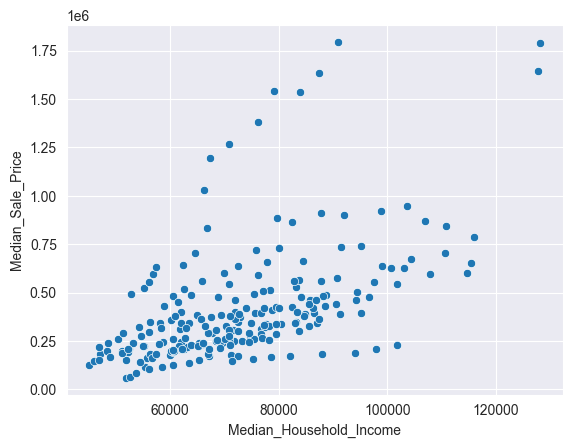

In [83]:
#Make a scatter plot of 'Median_Household_Income' vs 'Median_Sale_Price'
sns.scatterplot(data=housing_economic_data, x='Median_Household_Income', y='Median_Sale_Price')
plt.show()

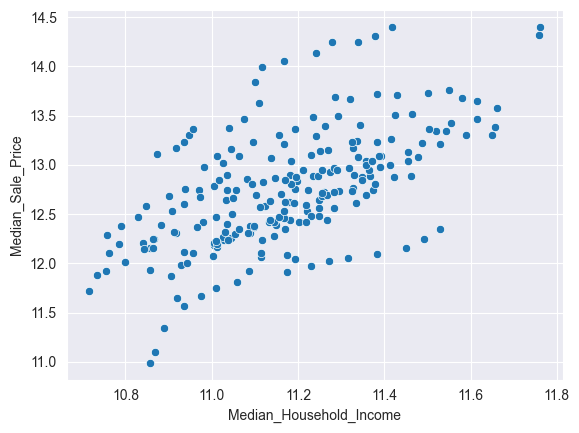

In [84]:
#Take the log of "Median_Household_Income' and the log of "Median_Sale_Price' and make a scatter plot
sns.scatterplot(data=housing_economic_data, x=np.log(housing_economic_data['Median_Household_Income']), y=np.log(housing_economic_data['Median_Sale_Price']))
plt.show()

Task clarification:
- Run the same home price regression within each Region using housing_economic_data.
- Model: Median_Sale_Price ~ Median_Household_Income + CurrentGDP + Annual_CPI + After_Tax_Income.
- Return a compact table of key metrics and coefficients by Region, and retain fitted models for optional inspection.

In [85]:
region_models = {}
rows = []
features = ['Median_Household_Income', 'CurrentGDP', 'Annual_CPI', 'After_Tax_Income']
formula = 'Median_Sale_Price ~ ' + ' + '.join(features)

for region, df_reg in housing_economic_data.groupby('Region', as_index=False):
    df_fit = df_reg.dropna(subset=['Median_Sale_Price'] + features)
    if len(df_fit) < 3:
        continue
    model = smf.ols(formula, data=df_fit).fit()
    region_models[region] = model
    row = {
        'Region': region,
        'N': int(model.nobs),
        'R2': model.rsquared,
        'Adj_R2': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
        'Intercept': model.params.get('Intercept', float('nan')),
        'b_Median_Household_Income': model.params.get('Median_Household_Income', float('nan')),
        'b_CurrentGDP': model.params.get('CurrentGDP', float('nan')),
        'b_Annual_CPI': model.params.get('Annual_CPI', float('nan')),
        'b_After_Tax_Income': model.params.get('After_Tax_Income', float('nan'))
    }
    rows.append(row)

per_region_regression_results = pd.DataFrame(rows).sort_values(['N', 'R2', 'Region'],
                                                               ascending=[False, False, True]).reset_index(drop=True)
per_region_regression_results

,Region,N,R2,Adj_R2,AIC,BIC,Intercept,b_Median_Household_Income,b_CurrentGDP,b_Annual_CPI,b_After_Tax_Income
0,Miami,12,0.989376,0.985392,269.294064,271.233691,-4.761563e+04,2.178372,0.001705,-1778.190508,2.169983
1,Boston,12,0.988423,0.981807,269.990110,272.414643,-2.251045e+05,-491.428922,0.000920,2699.058816,512.468478
2,San Diego,12,0.987731,0.983130,278.868329,280.807955,-7.151472e+04,0.269224,0.006096,-2564.557753,0.240441
3,Tampa,12,0.987672,0.983049,262.131971,264.071598,-1.343259e+05,1.050273,0.002219,-514.069265,1.041060
4,Denver,12,0.982514,0.972522,278.017474,280.442007,1.888461e+05,263.161760,0.004573,-3684.245028,-273.046822
5,Minneapolis,12,0.980165,0.968830,264.755295,267.179828,-2.906252e+05,-12.776471,0.000376,329.960278,19.056156
6,Riverside,12,0.979519,0.971838,275.154647,277.094274,-1.697180e+05,-1.766138,0.003471,1164.284076,-1.602811
7,Phoenix,12,0.972495,0.956778,277.961384,280.385918,-4.842870e+05,52.372124,0.000847,3649.438989,-54.028082
8,Seattle,12,0.970604,0.959581,289.783629,291.723256,7.577998e+04,-0.340561,0.002508,-1528.927379,-0.344794
9,Atlanta,12,0.970100,0.953014,274.047949,276.472482,-2.710421e+05,-16.496460,0.000526,893.696973,18.842090


In [86]:
if region_models:
    best_region = per_region_regression_results.iloc[0]['Region']
    print(f"Top Region by N then R2: {best_region}")
    print(region_models[best_region].summary())


Top Region by N then R2: Miami
                            OLS Regression Results                            
Dep. Variable:      Median_Sale_Price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     248.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           3.12e-08
Time:                        08:12:00   Log-Likelihood:                -130.65
No. Observations:                  12   AIC:                             269.3
Df Residuals:                       8   BIC:                             271.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

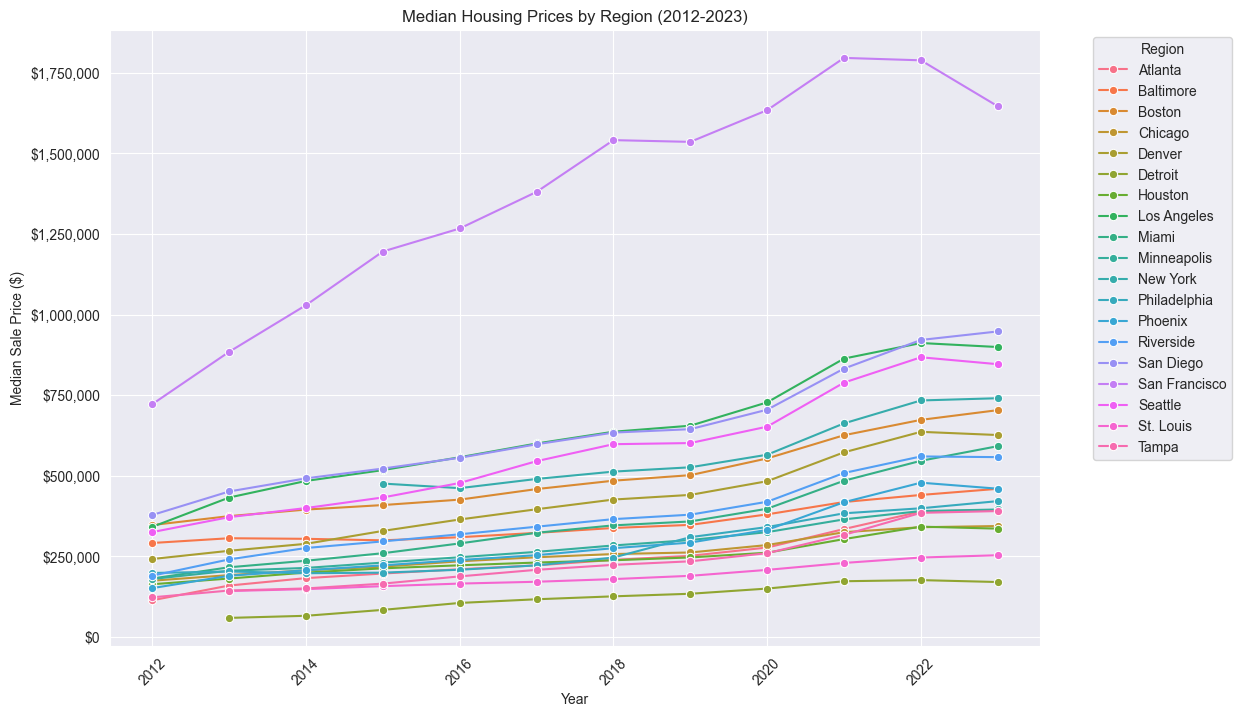

In [92]:
#Create a line plot that shows the 'Year' on the x-axis and 'Median_Sale_Price' on the y-axis for every 'Region' as a hue
plt.figure(figsize=(12, 8))
sns.lineplot(data=housing_economic_data, x='Year', y='Median_Sale_Price', hue='Region', marker='o')
plt.title('Median Housing Prices by Region (2012-2023)')
plt.xlabel('Year')
plt.ylabel('Median Sale Price ($)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

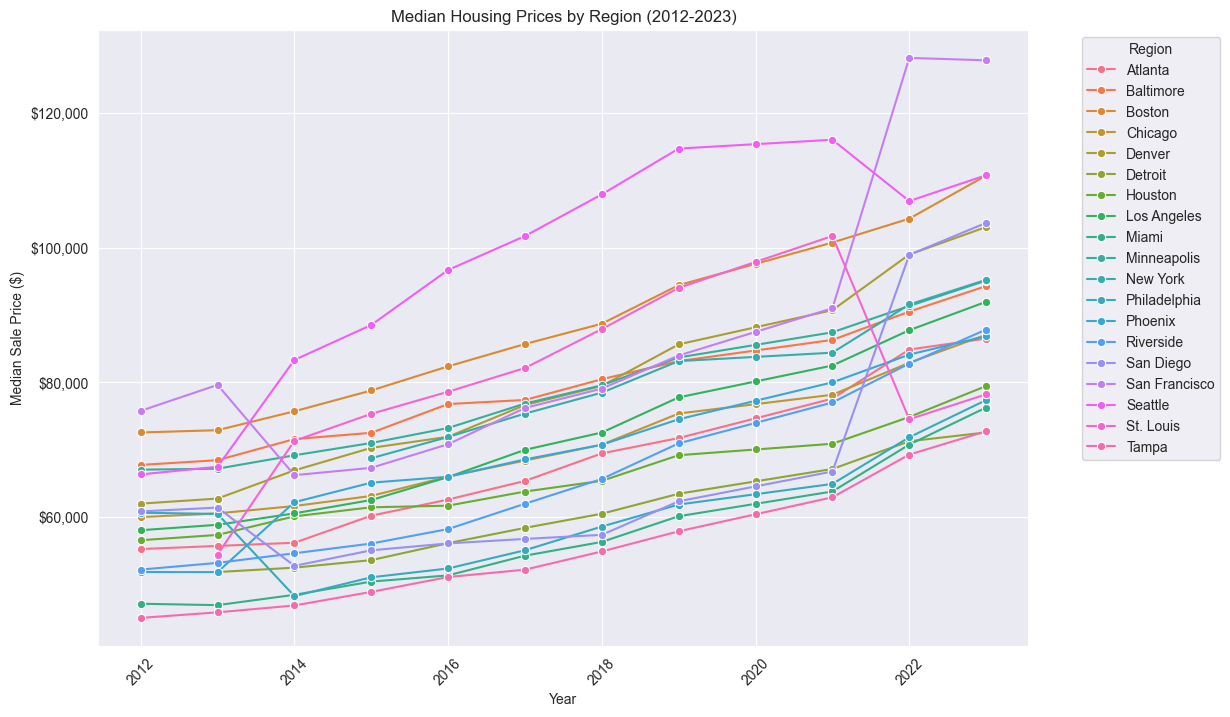

In [93]:
#Create a line plot with 'Median_Household_Income on the y-axis
plt.figure(figsize=(12, 8))
sns.lineplot(data=housing_economic_data, x='Year', y='Median_Household_Income', hue='Region', marker='o')
plt.title('Median Housing Prices by Region (2012-2023)')
plt.xlabel('Year')
plt.ylabel('Median Sale Price ($)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))